In [ ]:
import numpy as np
import eagle_constants_and_units as c
import cosmo_utils as csu
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from astropy import constants as const
from astropy import units as u

import get_halpha_SB
import HalphaSBplot_addnoise

%matplotlib inline

In [17]:
def getBackground(start,end,machine,plot=False):
    # Returns the total background flux in the wavlength interval supplied i.e. returns (flux)*(wavlength interval) 
    wavelength = []
    flux = []
    
    if machine=='chinook':
        geminiloc='/Users/lokhorst/Documents/Eagle/Gemini_skybackground.dat'
    elif machine=='coho':
        geminiloc='/Users/deblokhorst/Documents/Dragonfly/HalphaScripts/Gemini_skybackground.dat'
    
    with open(geminiloc,'r') as f:  #wavelength in nm, flux in phot/s/nm/arcsec^2/m^2
        for line in f:
            if line[0]!='#' and len(line)>5:
                tmp = line.split()
                wavelength.append(tmp[0])
                flux.append(tmp[1])
                
    wavelength = np.array(wavelength,'d')
    flux = np.array(flux,'d')
    
    start_ind = (np.abs(wavelength-start)).argmin()
    end_ind   = (np.abs(wavelength-end)).argmin()
    
    # if spacings are not even, need to add element by element
    total=0
    for index in np.arange(start_ind,end_ind):
      #  print index,index+1
      #  print total
        total = total+(flux[index]*(wavelength[index+1]-wavelength[index]))
        
    # if spacings are even, can just take the average of the flux array and times it by the total bandwidth
    np.mean(flux[start_ind:end_ind])*(wavelength[end_ind]-wavelength[start_ind])
    
   # print('start index and end index: %s and %s'%(start_ind,end_ind))
   # print(wavelength[start_ind:end_ind]-wavelength[start_ind+1:end_ind+1])
    if plot==True:
        plt.plot(wavelength[start_ind-100:end_ind+100],flux[start_ind-100:end_ind+100])
        top = max(flux[start_ind-100:end_ind+100])
        plt.plot([start,start,end,end,start],[0,top,top,0,0])
        plt.show()
        
    return total


In [18]:
def plotfilament(SBdata,ax,colmap='viridis',onlyyellow=False,contours=True,mockobs=False,labelaxes=False):
    # setting up the plot
    if mockobs:
        clabel = r'log signal (photons)'
    else:
        clabel = r'log photons/cm$^2$/s/sr'
    Vmin = None
    Vmax= None
    #fig = plt.figure(figsize = (7.5, 8.))
    #ax = plt.subplot(121)
    fontsize=13

    if labelaxes:
        ax.set_xlabel(r'X [cMpc]',fontsize=fontsize)
        ax.set_ylabel(r'Y [cMpc]',fontsize=fontsize)
        #xlabels = [0,0.6,1.2,1.8,2.4,3.0]
        #ax.set_xticks([0,5,10,15,20,25], minor=False)
        #ax.set_xticklabels(xlabels, minor=False)
        #ylabels = [ 0.,0.25,0.5]
        #ax.set_yticks([0,2.5,5], minor=False)
        #ax.set_yticklabels(ylabels, minor=False)
    
        ax.tick_params(labelsize=fontsize) #,top=True,labeltop=True)
        ax.xaxis.set_label_position('top') 
        ax.xaxis.tick_top()
        
    
    #colmap = 'viridis'#'gist_gray'#'plasma'#'viridis' #'afmhot'
    ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value

    
    ## If you only want to plot the SB greater than 1 photon/s/cm^2/arcsec^2 then do the following
    if onlyyellow:
        SBonlyyellow = SBdata
        SBonlyyellow[SBdata<0.] = -3.
        img = ax.imshow(SBonlyyellow.T,origin='lower', cmap=cm.get_cmap(colmap), vmin = Vmin, vmax=Vmax,interpolation='nearest')
        levels = [0,1,2]
        colours = ['yellow','cyan','purple']
    else:
        img = ax.imshow(SBdata.T,origin='lower',extent=(0,3.7,0,0.7), cmap=cm.get_cmap(colmap), vmin = Vmin, vmax=Vmax,interpolation='nearest')
        levels = np.array([-2,-1,0,1,2,3])
        colours = ('red','orange','yellow','cyan','purple','pink')
        #levels = np.array([-2,-1.5,-1,-0.5,0,0.3,1,1.5,2,2.5,3])
        #colours = ('red','black','orange','black','yellow','black','cyan','black','purple','black','pink')
    
    # plot contours
    cmap = cm.PRGn
    if contours:
        ax.contour(SBdata.T,levels,colors=colours)#,cmap=cm.get_cmap(cmap, len(levels) - 1),)

    div = axgrid.make_axes_locatable(ax)
    cax = div.append_axes("bottom",size="15%",pad=0.1)
    cbar = plt.colorbar(img, cax=cax,orientation='horizontal')
    cbar.solids.set_edgecolor("face")
    cbar.ax.set_xlabel(r'%s' % (clabel), fontsize=fontsize)
    #cbar.ax.set_ylabel(r'%s' % (clabel), fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)


In [19]:
def loaddata():
    sl = [slice(None,None,None), slice(None,None,None)]
    if machine=='chinook':
        homedir='/Users/lokhorst/Eagle/'
    elif machine=='coho':
        homedir='/Users/deblokhorst/eagle/SlicesFromNastasha/'

    # Simulation snapnum 28 (z = 0), xy box size: 100Mpc, z slice width: 5Mpc,
    files_SF_28 = [homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen12.5__fromSFR.npz',
                   homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen17.5__fromSFR.npz',
                   homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen2.5__fromSFR.npz',
                   homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen7.5__fromSFR.npz']

    files_noSF_28 = [homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen12.5_noSFR.npz',
                     homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen17.5_noSFR.npz',
                     homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen2.5_noSFR.npz',
                     homedir+'emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen7.5_noSFR.npz']
                 
    # Load a 5Mpc slice of data
    print('data1 ('+files_noSF_28[0]+')...')
    data1 = (np.load(files_noSF_28[0])['arr_0'])[sl]
    data1 = get_halpha_SB.imreduce(data1, round(factor), log=True, method = 'average')
    print('data11 ('+files_SF_28[0]+')...')
    data11 = (np.load(files_SF_28[0])['arr_0'])[sl]
    data11 = get_halpha_SB.imreduce(data11, round(factor), log=True, method = 'average')
    print('5 Mpc slice...')
    data_5 = np.log10(10**data1+10**data11)
    print('delete data1, data11...')
    del data1
    del data11
    
    return data_5



In [20]:
def changeres(distance,resolution,data):
    pixscale =  {'50Mpc': 0.237/1000.*(1.+0.0115), '100Mpc': 0.477/1000.*(1.+0.0235),'200Mpc': 0.928/1000.*(1.+0.047) , '500Mpc': 2.178/1000.*(1.+0.12)} ### Mpc / arcsec (comoving)
    simpixsize = 100./32000. ### Mpc / pixel is resolution of raw data 
    factor = round(pixscale[distance]*resolution/simpixsize)
    size = 32000.
    # LATER determine the current resolution of the data. FOR NOW assume current resolution is 100 Mpc/ 32000 pixels ~ 3 kpc/pixel

    # If the factors are not integer multiples of 32000., I'll trim the data first and then imreduce it
    if 32000.%((factor)) != 0.:
        times_factor_fits_in = int(32000./factor)
        newsize = times_factor_fits_in * factor
        print("Before reducing resolution, the original data was trimmed to size %s."%int(newsize))
        datanew = data[0:int(newsize),0:int(newsize)]
    else:
        datanew = data
        newsize = size

    return get_halpha_SB.imreduce(datanew, round(factor), log=True, method = 'average'), newsize, factor

In [21]:
def defineboxes(data,size=100.):
    # size in Mpc = total box size of data
    pixlength = float(data.shape[0])
    
    # Define boxes around the filaments (snapnum 28)
    xbox_3 = np.array([53,53,56,56])*pixlength/size
    ybox_3 = (np.array([9.2,10,8.5,7.7])-0.2)*pixlength/size
    xbox_2 = np.array([44.5,44.5,46,46])*pixlength/size
    #    xbox_2 = np.array([43,43,46,46])*pixlength/size
    ybox_2 = (np.array([(7.9+6.9)/2.,(8.05+7.05)/2.,7.05,6.9])-0.05+0.2)*pixlength/size
    #    ybox_2 = (np.array([7.9,8.05,7.05,6.9])-0.05+0.2)*pixlength/size
    ##    ybox_2 = (np.array([7.8,8.1,7.1,6.8])-0.05+0.2)*pixlength/size
    xbox_1 = (np.array([47.4,46.2,46.9,48.1])+0.5)*pixlength/size
    ybox_1 = np.array([10.5,14,14,10.5])*pixlength/size
    xboxes = {'1':xbox_1,'2':xbox_2,'3':xbox_3}
    yboxes = {'1':ybox_1,'2':ybox_2,'3':ybox_3}
    
    return xboxes, yboxes

In [22]:
def extractdata(xfull,yfull,data):
    SBdata = np.zeros(xfull.shape)
    for i in range(yfull.shape[0]):
        for j in range(yfull.shape[1]):
                SBdata[i,j]  = data[xfull[i,j],yfull[i,j]]
    return SBdata

def getSBatfilament(data,resolution,distance):
    datares, newsize, factor = changeres(distance,resolution,data) # change data to required resolution at selected distance
    xboxes, yboxes = defineboxes(datares)
    xfull, yfull= get_halpha_SB.indices_region(xboxes[boxnum].astype(int),yboxes[boxnum].astype(int)) 
    SBdata = extractdata(xfull,yfull,datares)
    return SBdata

In [198]:
def addnoise(data,resolution,exptime=10**3*3600.,CMOS=False):
    # Dragonfly info
    area_lens = np.pi*(14.3/2)**2 * 48.                 # cm^2, 48 * 14.3 cm diameter lenses
    pix_size = 2.8                                      # arcsec
    ang_size_pixel  = (pix_size * (1./206265.))**2      # rad^2, the pixel size of the CCD
    tau_l = 0.85                                        # transmittance of the Dragonfly lens
    tau_f = 1.                                          # transmittance of the Halpha filter -- assumed for now
    #B = getBackground(656.3,657.3,machine)              # *u.photon/u.second/u.arcsec**2/u.m**2  ****already multiplied by the bandwidth***
    B = 0.560633
    D = 0.04                                            # dark current (electrons / s) 
    if CMOS:
        print "Using new CMOS cameras..."
        QE = 0.70                                       # quantum efficiency of the CMOS detector
        R_squared = 2.**2                               # read noise (electrons)
    else:
        print "Using old cameras..."
        QE = 0.48                                       # quantum efficiency of the CCDs
        R_squared = 10.**2                              # read noise (electrons)
    
   # R_squared = 50.**2
    
    binpix_size = resolution # arcsec
    numpixel = round((binpix_size/pix_size)**2)
    print "the number of pixels is %s"%numpixel
    
    
    ### total signal incident in exposure time ###
    totsignal = 10**data * exptime # ( photons / cm^2 /sr )
    ### total signal detected (accounting for system efficiency) ###
    detsignal = totsignal * QE * tau_l * tau_f * area_lens * ang_size_pixel * numpixel
    print "the total object signal [electrons] detected ranges from: %s to %s"%(np.min(detsignal),np.max(detsignal))
    print "an example of the object signal [electrons] is: %s"%detsignal[0]

    ### ObjectShotNoise ###
    detsignal_noise = np.zeros((data.shape[0],data.shape[1]))
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            detsignal_noise[x][y]=np.random.normal(detsignal[x][y],np.sqrt(detsignal[x][y])) 
    print "an example of the object signal noise [electrons] is: %s"%detsignal_noise[0]
    
    
    ### BackgroundSkyNoise ###
    'background sky signal detected [B]=ph/s/arcsec^2/m^2, [B_sky]=ph/s (in a pixel)'
    B_sky = B * QE * tau_l * tau_f * area_lens*(1/100.)**2 * pix_size**2
    print "the background in the bandwidth is: %s"%B
    print "the background signal, B_sky [ph/s (in a pixel)], is: %s"%B_sky
    B_sky_inexptime = B_sky*exptime
    B_sky_total     = B_sky*exptime*numpixel    
    B_sky_array = np.zeros((data.shape[0],data.shape[1]))
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            B_sky_array[x][y]=np.random.normal(B_sky_total,np.sqrt(B_sky_total)) 
#            B_sky_array[x][y]=np.random.poisson(B_sky_total)
    B_sky_array_total = B_sky_array
    print "the mean total background signal, B_sky_total [electrons], is: %s"%B_sky_total
    print "the total background noisy signal [electrons] ranges from: %s to %s"%(np.min(B_sky_array_total),np.max(B_sky_array_total))
    
    ### ReadOutNoise ###
    numexposures = exptime/3600. # hour long exposures
    R_squared_array = np.zeros((data.shape[0],data.shape[1]))
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            R_squared_array[x][y]=np.mean(np.random.normal(np.sqrt(R_squared),np.sqrt(np.sqrt(B_sky)),int(numpixel)))**2   
    R_squared_total = R_squared * round(numexposures)
    R_squared_total_array = R_squared_array * round(numexposures)
    print "the R_squared value is: %s, so in %s exposures [per pixel], will have R_squared of: %s, %s"%(R_squared,numexposures,R_squared_total,R_squared_total_array[0])
    print "the total R_squared value [electrons] multiplying by numpix read out is: %s, %s"%((R_squared_total*numpixel),(R_squared_total_array[0]*numpixel))
    
    ### DarkCurrent ###
    D_total = D*exptime*numpixel
    D_array = np.zeros((data.shape[0],data.shape[1]))
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            D_array[x][y]=np.random.normal(D_total,np.sqrt(D_total)) 
    D_array_total = D_array
    print "the total dark current [electrons] is: %s , %s"%(D_total, D_array_total[0])

    sigma = np.sqrt(detsignal_noise + B_sky_array_total + D_array_total + R_squared_total_array*numpixel)
    print "an example total noise (not squarerooted) is: %s"%(detsignal + B_sky_array_total + D_array_total + R_squared_total_array*numpixel)[0]
    print "an example total noise (squarerooted) is: %s"%sigma[0]

    ###  The total signal = signal + noise ###
    noiseadded_signal = np.log10(detsignal_noise + sigma**2)
    
    return noiseadded_signal


In [9]:
    #-------------- pick your distance and desired resolution ---------------------------------------------#
    resolution = 100.  ### arcsec
    distance = '50Mpc'  ### '50Mpc' '100Mpc' '200Mpc' '500Mpc'
    boxnum = '1' ### which filament (there are 3)
    factor = 1
    machine='coho'
    #------------------------------------------------------------------------------------------------------#

In [10]:
 data_5 = loaddata()

data1 (/Users/deblokhorst/eagle/SlicesFromNastasha/emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen12.5_noSFR.npz)...
data11 (/Users/deblokhorst/eagle/SlicesFromNastasha/emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen12.5__fromSFR.npz)...


get_halpha_SB.py:36: RuntimeWarning: divide by zero encountered in log10
  inimg = np.log10(inimg)


5 Mpc slice...
delete data1, data11...


In [202]:
resolution = 500.
SBdata = getSBatfilament(data_5,resolution,distance)
#np.savez('SBdata_1000arcsec.npz',SBdata)

Before reducing resolution, the original data was trimmed to size 31996.
xacross_length,yacross_length,xdown_length,ydown_length:  6, 0, -10, 29
xacross_length > yacross_length:
iterable: [ 0.  0.  0.  0.  0.  0.  0.]
xdown_length < ydown_length:
iterable: [ -0.  -0.  -1.  -1.  -1.  -2.  -2.  -2.  -3.  -3.  -3.  -4.  -4.  -4.  -5.
  -5.  -6.  -6.  -6.  -7.  -7.  -7.  -8.  -8.  -8.  -9.  -9.  -9. -10. -10.]


In [171]:
SBdata.shape

(30, 7)

In [174]:
SBdata_loaded = np.load('SBdata_500arcsec.npz')['arr_0']

In [178]:
SBdata_loaded.shape

(30, 7)

Here down is where we can mess around with things:

Using new CMOS cameras...
the number of pixels is 31888.0
the total object signal [electrons] detected ranges from: 90.0557016839 to 6937995559.83
an example of the object signal [electrons] is: [  726.89623109  1115.06429772  2119.90561268  4698.06775117  5928.38816209
  6738.57444368  3164.88833722]
an example of the object signal noise [electrons] is: [  750.17620423  1104.11107899  2103.06121435  4705.05596644  6010.98411779
  6861.38474904  3139.58272127]
the background in the bandwidth is: 0.560633
the background signal, B_sky [ph/s (in a pixel)], is: 2.01611304518
the mean total background signal, B_sky_total [electrons], is: 2.31443326025e+11
the total background noisy signal [electrons] ranges from: 231442146302.0 to 231444452980.0
the R_squared value is: 4.0, so in 1000.0 exposures [per pixel], will have R_squared of: 4000.0, [ 3986.8057722   4006.67864322  3980.53715885  4017.68515746  3984.38444874
  3998.26386844  3970.2987352 ]
the total R_squared value [electrons] multip

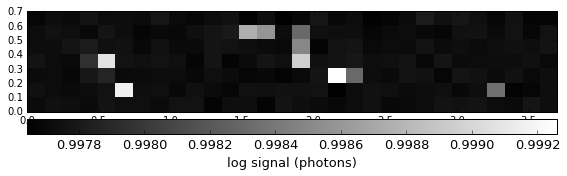

In [199]:
exptime=10**3*3600.
SBdata_exp0 = addnoise(SBdata,resolution,exptime=exptime,CMOS=True)
mockobs_sub = SBdata_exp0 - (int(np.min(SBdata_exp0)*100000)/100000.)
fig = plt.figure(figsize = (9.5, 5.))
ax1 = plt.subplot(111)
plotfilament(mockobs_sub**0.0002,ax1,contours=False,mockobs=True,colmap='gist_gray')
plt.savefig('mockobs_res%sas_exptime%shr_straightskyadd_poisson.png'%(resolution,round(exptime/3600.)))

In [68]:
    area_lens = np.pi*(14.3/2)**2 * 48.                 # cm^2, 48 * 14.3 cm diameter lenses
    pix_size = 2.8                                      # arcsec
    ang_size_pixel  = (pix_size * (1./206265.))**2      # rad^2, the pixel size of the CCD
    tau_l = 0.85                                        # transmittance of the Dragonfly lens
    tau_f = 1.                                          # transmittance of the Halpha filter -- assumed for now
    B = getBackground(656.3,657.3,machine)              # *u.photon/u.second/u.arcsec**2/u.m**2  ****already multiplied by the bandwidth***
    D = 0.04                                            # dark current (electrons / s) 
    CMOS=True
    if CMOS:
        print "Using new CMOS cameras..."
        QE = 0.70                                       # quantum efficiency of the CMOS detector
        R_squared = 2.**2                               # read noise (electrons)
    else:
        print "Using old cameras..."
        QE = 0.48                                       # quantum efficiency of the CCDs
        R_squared = 10.**2                              # read noise (electrons)
    R_squared = 50.**2

Using new CMOS cameras...


In [32]:
binpix_size = resolution # arcsec
numpixel = round((binpix_size/pix_size)**2)
print "the number of pixels is %s"%numpixel

the number of pixels is 31888.0


In [35]:
exptime=10**2*3600.
totsignal = 10**SBdata * exptime # ( photons / cm^2 /sr )
detsignal = totsignal * QE * tau_l * tau_f * area_lens * ang_size_pixel * numpixel


In [56]:
print('Raw signal (ph per sec per area per angular area per second): %f ph/pix/cm^2/arcsec^2/s' % (10**SBdata[3][0]))
print('Raw signal in the exposure time (%s hr): %f ph/pix/cm^2/arcsec^2' % ((exptime/3600.),totsignal[3][0]))
print('Detected signal (in a %s\" by %s\" binned pixel): %f electrons' % (resolution,resolution,detsignal[3][0]))

Raw signal (ph per sec per area per angular area per second): 0.054995 ph/pix/cm^2/arcsec^2/s
Raw signal in the exposure time (100.0 hr): 19798.220805 ph/pix/cm^2/arcsec^2
Detected signal (in a 500.0" by 500.0" binned pixel): 533.627970 electrons


In [69]:

print(B)
B_sky = B * QE * tau_l * tau_f * area_lens*(1/100.)**2 * pix_size**2
print("Background signal per second: %f"%B_sky)
B_sky_total = B_sky*exptime*numpixel
print("Background signal in exposure time (in a %s\" by %s\" binned pixel): %s electrons"%(resolution,resolution,B_sky_total))
print("Sqrt background signal in exposure time (in a %s\" by %s\" binned pixel): %s electrons"%(resolution,resolution,np.sqrt(B_sky_total)))

0.560633
Background signal per second: 2.016113
Background signal in exposure time (in a 500.0" by 500.0" binned pixel): 23144332602.5 electrons
Sqrt background signal in exposure time (in a 500.0" by 500.0" binned pixel): 152132.615183 electrons


Straight from the Gemini data:

In [66]:
# 0.5079 phot/s/nm/arcsec^2/m^2 is the background flux value around 656.3 nm
B_incident = 0.5079 * exptime * 1.0 * pix_size**2 * numpixel * area_lens*(1/100.)**2
print B_incident
B_detected = B_incident * QE * tau_l * tau_f
print B_detected

35239298246.5
20967382456.6


The second value is on the same order-of-magnitude as the B_sky_total so we are not crazily off.  It looks like our background value is a little too high though.

In [71]:
numexposures = exptime/3600. # hour long exposures
R_squared_allexp = R_squared * round(numexposures)
R_squared_total  = R_squared_allexp*numpixel
print R_squared_total

7972000000.0


In [ ]:
'background sky signal detected [B]=ph/s/arcsec^2/m^2, [B_sky]=ph/s (in a pixel)'
    # add noise to the background sky signal by replacing each value with a random value taken from a gaussian distribution with a mean of its value and st dev of sqrt of its value
    # set up array to contain sky background noise, use mean from the number of pixels bin over to make the map
    B_sky_array = np.zeros((data.shape[0],data.shape[1]))
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            B_sky_array[x][y]=np.mean(np.random.normal(B_sky,np.sqrt(B_sky),int(numpixel)))    
    B_sky_total = B_sky*exptime*numpixel
    B_sky_array_total = B_sky_array*exptime*numpixel
    print "the mean total background signal, B_sky_total [electrons], is: %s"%B_sky_total
    print "the total background noisy signal [electrons] ranges from: %s to %s"%(np.min(B_sky_array_total),np.max(B_sky_array_total))
    
    ### ReadOutNoise ###
    numexposures = exptime/3600. # hour long exposures
    R_squared_array = np.zeros((data.shape[0],data.shape[1]))
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            R_squared_array[x][y]=np.mean(np.random.normal(np.sqrt(R_squared),np.sqrt(np.sqrt(B_sky)),int(numpixel)))**2   
    R_squared_total = R_squared * round(numexposures)
    R_squared_total_array = R_squared_array * round(numexposures)
    print "the R_squared value is: %s, so in %s exposures [per pixel], will have R_squared of: %s"%(R_squared,numexposures,R_squared_total)
    print "the total R_squared value [electrons] multiplying by numpix read out is: %s"%(R_squared_total*numpixel)
    
    ### DarkCurrent ###
    print "the total dark current [electrons] is: %s "%(D*exptime*numpixel)
    # to do: add noise to dark current and read noise?
    
    sigma = np.sqrt(detsignal + B_sky_array*exptime*numpixel + D*exptime*numpixel + R_squared_total*numpixel)
    print "the total noise (not squarerooted) is: %s"%(detsignal + B_sky_array*exptime*numpixel + D*exptime*numpixel + R_squared_total*numpixel)
    print "the total noise (squarerooted) is: %s"%sigma

    return B_sky_array, np.log10(detsignal + sigma)
